This notebook shows how to format order book data (data category "OB Data") downloaded from https://www.bybit.com/derivatives/en/history-data

In [25]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


In [26]:
# file name
flow_file = '2024-09-03_BTCUSDT_ob500.txt'


# read the number of rows in file
def number_of_rows(file_path):
    with open(file_path, 'r') as file:
        rows = file.readlines()
        return len(rows)

# maximum number of rows
max_n_of_rows = number_of_rows(flow_file)
print(max_n_of_rows)


863839


In [27]:
# number of datapoints in a day
60 * 60 * 24 * 10

864000

In [28]:
# number of rows of file to process
rows_to_process = 10000

# maximum bid and ask depth
max_depth = 20

rows_to_process = min(rows_to_process, max_n_of_rows)

In [29]:
def read_data(flow_file):
    dict_a = {} # dictionary with ask data
    dict_b = {} # dictionary with bid data

    # read row by row the txt file
    with open(flow_file, 'r') as file:
        for n in tqdm(range(rows_to_process)):

            riga = file.readline()
            riga = riga.strip().strip("'")
            obj = json.loads(riga) # it's a json object

            # get the data
            ts = obj['ts']
            a = obj['data']['a']
            b = obj['data']['b']

            # if data is empty continue
            if (not a) or (not b):
                continue
            
            # populate the dictionaries
            dict_a[ts] = a[:max_depth]
            dict_b[ts] = b[:max_depth]

    return dict_a, dict_b


def build_order_flow_dataframe(dict_a, dict_b):

    def format_df(dictionary):
        # build a dataframe from dictionary
        df = pd.DataFrame(pd.DataFrame().from_dict(dictionary, orient='index').stack())

        df = pd.DataFrame(df[0].tolist(), index=df.index)
        df = df.rename(columns={0: 'price', 1: 'volume'})

        return df
    
    ask_df = format_df(dict_a)
    ask_df['side'] = 'ask'

    bid_df = format_df(dict_b)
    bid_df['side'] = 'bid'

    flow_df = pd.concat([ask_df, bid_df])
    flow_df = flow_df.reset_index()
    flow_df['level_0'] = pd.to_datetime(flow_df['level_0'], unit='ms')
    flow_df = flow_df.rename(columns={'level_0': 'time', 'level_1': 'level'})

    flow_df = flow_df.set_index(['time', 'side', 'level'])
    flow_df = flow_df.sort_index()

    flow_df['price'] = flow_df['price'].astype(float)
    flow_df['volume'] = flow_df['volume'].astype(float)

    return flow_df


def plot_order_book(df):
    # sort to prepare to cumsum the volumes
    bid_data = df.loc['bid'].sort_values(by='price', ascending=False)
    ask_data = df.loc['ask'].sort_values(by='price', ascending=True)

    # cumulative volumes
    bid_data['cumulative_volume'] = bid_data['volume'].cumsum()
    ask_data['cumulative_volume'] = ask_data['volume'].cumsum()

    # useful to fill price gaps
    price_range_bid = np.linspace(bid_data['price'].max(), bid_data['price'].min(),
                                num=int(round(bid_data['price'].max() - bid_data['price'].min(), 1) * 10) + 1)

    price_range_ask = np.linspace(ask_data['price'].min(), ask_data['price'].max(),
                                num=int(round(ask_data['price'].max() - ask_data['price'].min(), 1) * 10) + 1)

    # sort again the bid data
    bid_data = bid_data.sort_index(ascending=True)


    fig = plt.figure()

    # build a dataframe for each cum volume, in order to fill the gaps
    cum_vol_bid = pd.DataFrame({'price': price_range_bid}).set_index('price').join(
        bid_data.set_index('price')['cumulative_volume'], how='left').ffill()

    cum_vol_ask = pd.DataFrame({'price': price_range_ask}).set_index('price').join(
        ask_data.set_index('price')['cumulative_volume'], how='left').ffill()

    # now plot
    plt.figure(figsize=(10, 6))

    # bid
    plt.plot(cum_vol_bid.index, cum_vol_bid['cumulative_volume'], color='green', label='Bid')
    plt.fill_between(cum_vol_bid.index, cum_vol_bid['cumulative_volume'], color='green', alpha=0.3)

    # ask
    plt.plot(cum_vol_ask.index, cum_vol_ask['cumulative_volume'], color='red', label='Ask')
    plt.fill_between(cum_vol_ask.index, cum_vol_ask['cumulative_volume'], color='red', alpha=0.3)

    # labels and title
    plt.ylabel('Cumulative Volume [BTC]')
    plt.xlabel('Price [USDT]')
    plt.title('Market Depth')
    plt.legend()

    plt.show()

In [30]:
dict_a, dict_b = read_data(flow_file)
flow_df = build_order_flow_dataframe(dict_a, dict_b)

100%|██████████| 10000/10000 [00:01<00:00, 7998.38it/s]


In [31]:
flow_df.head()

price  volume
time                    side level                 
2024-09-03 00:00:01.755 ask  0      59116.8   6.618
                             1      59117.1   0.001
                             2      59117.2   0.017
                             3      59117.3   0.002
                             4      59117.6   0.050

<Figure size 640x480 with 0 Axes>

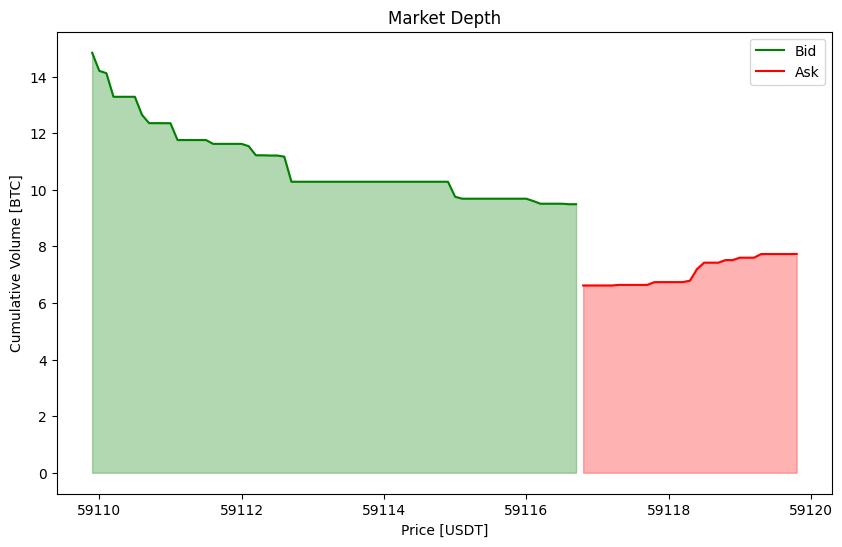

In [32]:
plot_order_book(flow_df.loc[flow_df.index.get_level_values('time')[0]])